# Trilep analysis development



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.trilep_analysis import trilep_analysis
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [ ]:
# an equivalent code can be run with ipython -i trilep_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small

overwrite = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'trilep_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

fileset = {
    'topW_v3': fileset_2018['topW_v3'],
    #'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    #'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'diboson': fileset_2018['diboson'],
    'ttbar': fileset_2018['top2l'],
    'DY': fileset_2018['DY'],
}

# add all processes to output so that the cutflow doesn't fail
add_processes_to_output(fileset, desired_output)

# add some histograms that we defined in the processor
# everything else is taken the default_accumulators.py
from processor.default_accumulators import mass_axis, dataset_axis
desired_output.update({
    "dilep_mass": hist.Hist("Counts", dataset_axis, mass_axis),
})

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        trilep_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()


I'm running now


Preprocessing:   0%|          | 0/268 [00:00<?, ?file/s]

Processing:   0%|          | 0/591 [00:00<?, ?chunk/s]

In [26]:
# we can just take the process list from the fileset to avoid any confusions
processes = list(fileset.keys())

# the following list is directly taken from Tools/selection.py
lines = ['entry']
lines += [
            'filter',
            'lepveto',
            'trilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'offZ',
            'N_jet>2',
            'N_central>1',
            'N_btag>0',
            'N_fwd>0',
        ]

from Tools.helpers import getCutFlowTable
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,S/B
entry,226.3 +/- 0.2,15200.0 +/- 30.0,12400.0 +/- 10.0,11630.0 +/- 10.0,748400.0 +/- 300.0,4391000.0 +/- 1000.0,0.0000
filter,226.0 +/- 0.2,15180.0 +/- 30.0,12390.0 +/- 10.0,11610.0 +/- 10.0,748100.0 +/- 300.0,4390000.0 +/- 1000.0,0.0000
lepveto,29.62 +/- 0.09,462.3 +/- 3.1,1872.0 +/- 3.0,488.8 +/- 1.2,30390.0 +/- 50.0,95420.0 +/- 110.0,0.0002
trilep,5.945 +/- 0.038,76.55 +/- 0.81,506.7 +/- 1.7,69.44 +/- 0.46,8279.0 +/- 27.0,202.9 +/- 4.5,0.0007
p_T(lep0)>25,5.935 +/- 0.038,76.47 +/- 0.81,506.4 +/- 1.7,69.21 +/- 0.46,8265.0 +/- 27.0,201.4 +/- 4.5,0.0007
p_T(lep1)>20,5.895 +/- 0.038,75.98 +/- 0.81,503.4 +/- 1.7,68.34 +/- 0.46,8217.0 +/- 27.0,196.8 +/- 4.5,0.0007
trigger,5.685 +/- 0.037,73.06 +/- 0.8,484.7 +/- 1.7,64.89 +/- 0.45,7752.0 +/- 26.0,184.0 +/- 4.3,0.0007
offZ,4.958 +/- 0.035,63.78 +/- 0.74,81.53 +/- 0.67,53.89 +/- 0.41,1080.0 +/- 10.0,151.1 +/- 3.9,0.0035
N_jet>2,4.308 +/- 0.032,35.75 +/- 0.59,65.66 +/- 0.61,42.37 +/- 0.36,152.2 +/- 3.8,55.62 +/- 2.35,0.0123
N_central>1,4.198 +/- 0.031,34.89 +/- 0.59,63.23 +/- 0.6,41.41 +/- 0.36,131.2 +/- 3.5,50.91 +/- 2.21,0.0131


In [27]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar
entry,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
filter,0.9987,0.9987,0.9988,0.9987,0.9995,0.9996
lepveto,0.1310,0.0305,0.1511,0.0421,0.0406,0.0217
trilep,0.2007,0.1656,0.2706,0.1420,0.2724,0.0021
p_T(lep0)>25,0.9984,0.9990,0.9994,0.9968,0.9983,0.9927
p_T(lep1)>20,0.9933,0.9936,0.9942,0.9875,0.9942,0.9772
trigger,0.9643,0.9616,0.9629,0.9495,0.9434,0.9346
offZ,0.8721,0.8729,0.1682,0.8304,0.1394,0.8214
N_jet>2,0.8690,0.5605,0.8053,0.7861,0.1409,0.3680
N_central>1,0.9744,0.9759,0.9630,0.9774,0.8615,0.9154


In [34]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 200)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v3': 'top-W scat.',
    'TTZ': r'$t\bar{t}Z$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'ttbar': r'$t\bar{t}$',
}

my_colors = {
    'topW_v3': '#FF595E',
    'TTZ': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'ttbar': '#1982C4',
}

Data: 0 MC: 74.18
Data: 0 MC: 74.18


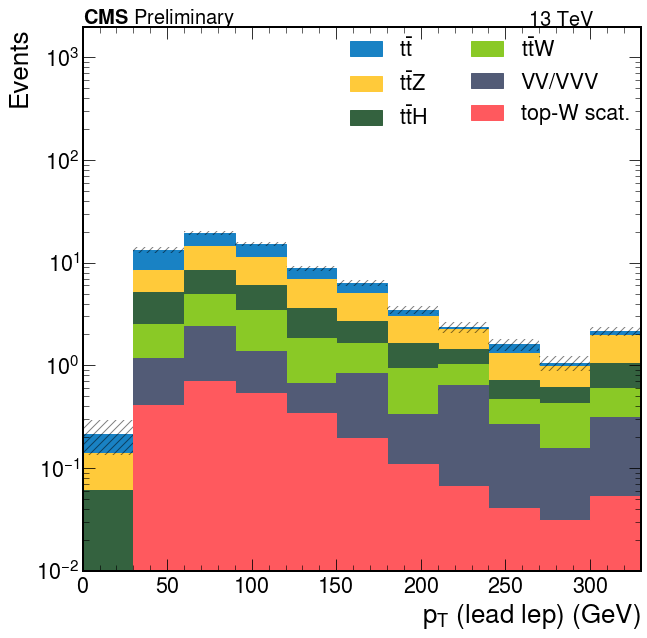

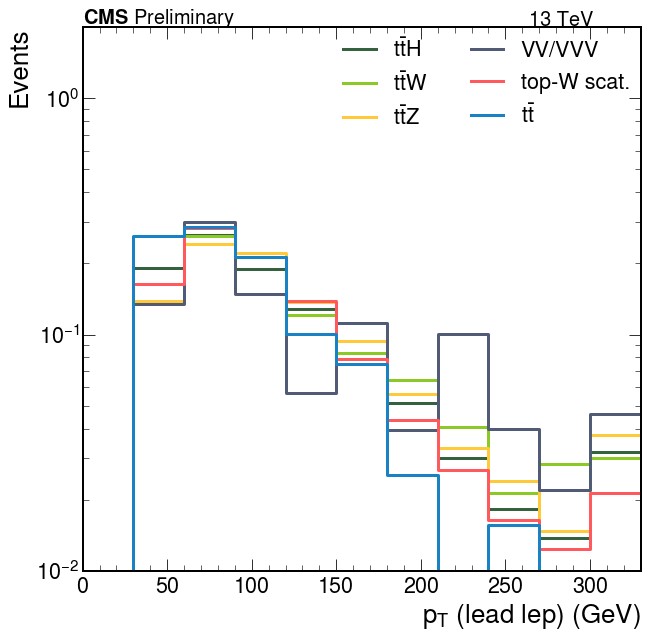

In [37]:
makePlot(output, 'lead_lep', 'pt',
         data_sel=None,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
        )
makePlot(output, 'lead_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
        )

Data: 0 MC: 225.78
Data: 0 MC: 225.78


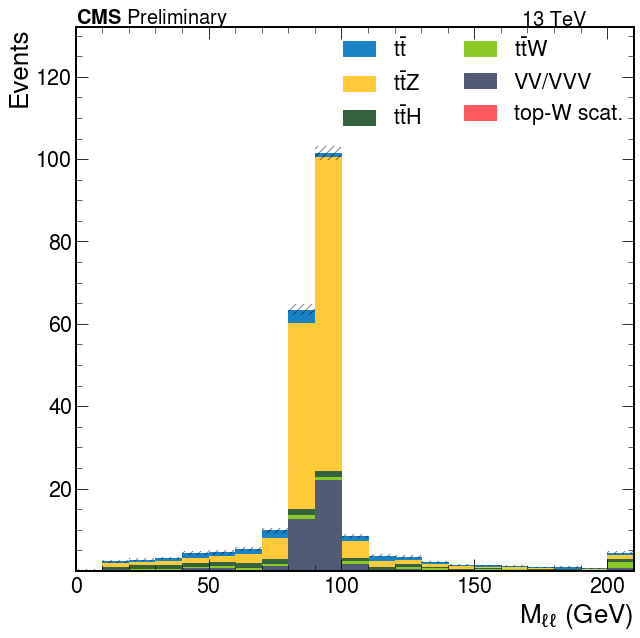

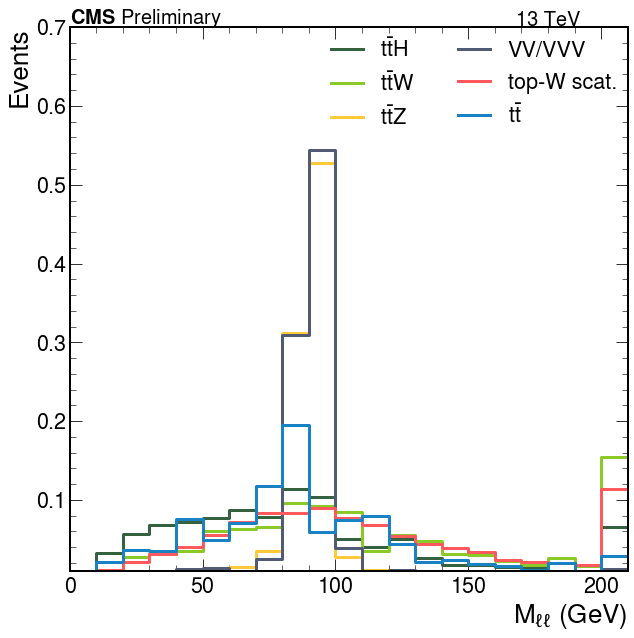

In [38]:
makePlot(output, 'mll_mass', 'mass',
         data_sel=None,
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson',  'TTW', 'TTH', 'TTZ', 'ttbar'],
        )
makePlot(output, 'mll_mass', 'mass',
         data_sel=None,
         shape=True,
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         ymax=0.7,
        )